In [1]:
%matplotlib inline
from bivariate import *
from utils import *
from enc import *
from plots import *
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
# from torch.distributions.one_hot_categorical import OneHotCategorical as cat

### Gibbs Sampling

In [2]:
# ## Define a target bivariate Gaussian for unit test
# mu1 = torch.ones(1) * 5.0
# mu2 = torch.ones(1) * 8.0
# sigma1 = torch.ones(1) * 1.0
# sigma2 = torch.ones(1) * 2.5
# rho = torch.ones(1) * 0.6

# bg = Bi_Gaussian(mu1, mu2, sigma1, sigma2, rho, CUDA=False, device=None)

# STEPS = 10

# updates = Gibbs(bg, STEPS, sampling=False)

In [3]:
# Plot_updates(updates, bg, sigma_factor=5, pts=1000, fs=10, levels=5, back_to_cpu=False)

### Amortized Gibbs Sampling

In [4]:
GRAD_STEPS = 2000
LEARNING_RATE = 1e-3
NUM_SAMPLES = 10
MCMC_STEPS = 10
NUM_HIDDENS = 8

CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

In [5]:
## Define a target bivariate Gaussian for unit test
mu1 = torch.ones(1) * 5.0
mu2 = torch.ones(1) * 8.0
sigma1 = torch.ones(1) * 1.0
sigma2 = torch.ones(1) * 2.5
rho = torch.ones(1) * 0.6

q_x1 = Kernel(NUM_HIDDENS, mu1, sigma1, CUDA, DEVICE)
q_x2 = Kernel(NUM_HIDDENS, mu2, sigma2, CUDA, DEVICE)
bg = Bi_Gaussian(mu1, mu2, sigma1, sigma2, rho, CUDA=True, device=DEVICE)

if CUDA:
     with torch.cuda.device(DEVICE):
        q_x1.cuda()
        q_x2.cuda()
optimizer = torch.optim.Adam(list(q_x1.parameters())+list(q_x2.parameters()), lr=LEARNING_RATE)

# obj = 'ag'

# if obj == 'ag':
#     q_x1.load_state_dict(torch.load('q_x1'))
#     q_x2.load_state_dict(torch.load('q_x2'))
# else:
#     q_x1.load_state_dict(torch.load('q_x1_alternative'))
#     q_x2.load_state_dict(torch.load('q_x2_alternative'))

In [6]:
LOSSS = []
ESSS = []
time_start = time.time()
for i in range(GRAD_STEPS):
    optimizer.zero_grad()
    loss, ess = bg.train(q_x1, q_x2, MCMC_STEPS, NUM_SAMPLES, sampled=True, obj='ag')
    loss.backward()
    optimizer.step()
    LOSSS.append(loss)
    ESSS.append(ess)
    if i % 100 == 0:
        time_end = time.time()
        print('Step=%d, Loss=%.4f, ESS=%.4f (%ds)' % (i, loss, ess, time_end - time_start))
        time_start = time.time()

Step=0, Loss=-63.4142, ESS=4.6976 (0s)
Step=100, Loss=-16.6036, ESS=4.1201 (7s)
Step=200, Loss=-0.3749, ESS=6.8581 (6s)
Step=300, Loss=1.8086, ESS=7.2896 (6s)
Step=400, Loss=1.2315, ESS=8.1948 (6s)
Step=500, Loss=1.9189, ESS=7.3172 (6s)
Step=600, Loss=1.6105, ESS=7.4460 (6s)
Step=700, Loss=2.6278, ESS=7.8217 (6s)
Step=800, Loss=0.7884, ESS=8.3529 (6s)
Step=900, Loss=0.7200, ESS=7.8475 (6s)
Step=1000, Loss=2.2066, ESS=7.0473 (6s)
Step=1100, Loss=1.3766, ESS=8.5803 (6s)
Step=1200, Loss=2.2911, ESS=7.5676 (6s)
Step=1300, Loss=1.3722, ESS=8.3072 (6s)
Step=1400, Loss=1.7180, ESS=8.2646 (6s)
Step=1500, Loss=1.9299, ESS=8.0051 (6s)
Step=1600, Loss=0.1994, ESS=7.8188 (6s)
Step=1700, Loss=2.1714, ESS=7.5187 (6s)
Step=1800, Loss=3.0463, ESS=8.3662 (6s)
Step=1900, Loss=1.1479, ESS=8.0582 (6s)


In [7]:
torch.save(q_x1.state_dict(), 'q_x1_alternative')
torch.save(q_x2.state_dict(), 'q_x2_alternative')

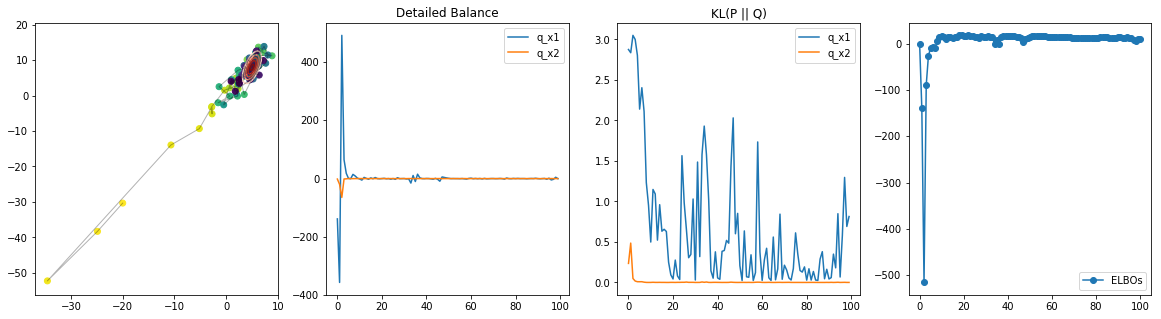

In [9]:
x0 = torch.ones(1).cuda().to(DEVICE).unsqueeze(0) * -20
updates, DBs, KLs, ELBOs = bg.test(q_x1, q_x2, 100, 1, sampled=True, init=x0)
Plot_updates(ELBOs, DBs, KLs, updates, bg, sigma_factor=5, pts=100, fs=5, levels=5)
plt.savefig('biGaissuan_results2.pdf')

In [ ]:
ELBOs.shape

In [ ]:
plt.plot(ELBOs.cpu().data.numpy())